<img src="../images/GA-logo.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Singapore Housing Data and Kaggle Challenge

**Primary Learning Objectives:**

1. Creating and iteratively refining a regression model
2. Using Kaggle to practice the modeling process
3. Providing business insights through reporting and presentation.

We will clean the data and build a regression model based on Singapore Housing Dataset to predict the price of a house at sale.

This jupyter notebook focuses on constructing the production predictive model and discussees the business insights

----

### Contents:
- [Data and Preprocessor Import](#Data-and-Preprocessor-Import)
- [Production Model Construction](#Production-Model-Construction)
- [Business Insights Discussion](#Business-Insights-Discussion)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

In [1]:
import dill
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

from subsegment_model import SubsegmentModel

----

## Data and Preprocessor Import

In [2]:
# import clean data
X = pd.read_csv('../datasets/X.csv', index_col='Unnamed: 0')
y = pd.read_csv('../datasets/y.csv', index_col='Unnamed: 0').squeeze()

In [3]:
# define folder path for models
folder_path = '../models/'

In [4]:
# load preprocessor
preprocessor_C = dill.load(open(folder_path + 'preprocessor_C.sav', 'rb'))
preprocessor_D = dill.load(open(folder_path + 'preprocessor_D.sav', 'rb'))

In [5]:
# load regression transformer
lr_log_model = dill.load(open(folder_path + 'lr_log.sav', 'rb'))

----

## Production Model Construction

We will fit the production model on the full dataset without splitting it into train and test

In [6]:
# fit model on full dataset
model_production_segment = Pipeline(
    steps=[
        ('preproc', preprocessor_D),
        ('regr', lr_log_model)
    ]
)

model_production = SubsegmentModel(model_production_segment, 'planning_area_grouped')

model_production.fit(X, y)

### Evaluate production model

In [7]:
# generate RMSE metric
y_pred = model_production.predict(X)

print(f'RMSE: {np.sqrt(mean_squared_error(y, y_pred))}')

RMSE: 39825.95705228313


<img src='../images/Kaggle_submission_v4.png'>

Observation:

- Based on the evaluation metric of root-mean-squared-error (RMSE), the production model performs well, with a public score of 39,226 and a private score of 40,700.

### Export production model

In [8]:
dill.dump(model_production, open('../models/model_production.sav', 'wb'))

----

## Business Insights Discussion

Examining this model, we discuss some of the key insights in predicting HDB resale prices

First, we realise that a log(resale price) model is difficult to interpret (additional explanation [here](https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9#:~:text=As%20you%20can%20see%2C%20log,to%20interpreting%20the%20model's%20coefficients))

Second, we note that sub-segment model significantly increases the complexity of the analysis and business insights (i.e. each sub-segment effectively has its own model)

Hence, for the purposes of business insights, we will use Model C instead of the production model by having the regressor use direct resale price without taking the log and a single model for all planning areas rather than the sub-segment model. This will reduce the performance of the model somewhat (as seen in 03_Model_Tuning_and_Evaluation notebook) - RMSE is expected to rise by $30k or so

In [9]:
# build simplified production model
model_explanation = Pipeline(
    steps=[
        ('preproc', preprocessor_C),
        ('regr', LinearRegression())
    ]
)

model_explanation.fit(X, y)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['planning_area',
                                                   'full_flat_type']),
                                                 ('imp', KNNImputer(),
                                                  ['mall_nearest_distance']),
                                                 ('poly_hawk',
                                                  PolynomialFeatures(include_bias=False,
                                                                     interaction_only=True),
                                                  ['hawker_nearest_distance',
                                                   'hawker_within_2km']),
                                                 ('poly_mrt',
                                                  P...mialFeatures(include_bias=False,
                                                                     interaction_only=True),
                                                  ['mrt_nearest_distance',
                                                   'mrt_interchange',
                                                   'bus_interchange']),
                                                 ('dummy',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x0000027D5F2439D0>),
                                                  ['hdb_age', 'mid',
                                                   'floor_area_sqft',
                                                   'tranc_year',
                                                   'tranc_month'])],
                                   verbose_feature_names_out=False)),
                ('regr', LinearRegression())])

In [10]:
# examine coefficients of predictor variables
model_coef = pd.DataFrame(model_explanation['regr'].coef_.transpose(), 
                          index=model_explanation['preproc'].get_feature_names_out(),
                          columns=['coefficient']
                         )

model_coef.reset_index(inplace=True)
model_coef.rename(columns={'index':'variable'}, inplace=True)
model_coef.sort_values(by='coefficient', ascending=False, inplace=True)

In [11]:
# categorise the variables for easier interpretation
model_coef['category'] = [
    'full_flat_type' if 'full_flat_type' in var
    else 'planning_area' if 'planning_area' in var
    else 'mrt' if ('mrt' in var) | ('bus' in var)
    else 'hawker' if 'hawker' in var
    else 'storey' if var == 'mid'
    else 'mall' if 'mall' in var
    else 'time' if 'tranc' in var
    else var
    for var in model_coef['variable']
]

In [12]:
# check out the categories of variables
set(model_coef['category'])

{'floor_area_sqft',
 'full_flat_type',
 'hawker',
 'hdb_age',
 'mall',
 'mrt',
 'planning_area',
 'storey',
 'time'}

### Variables with largest influence on resale price

In [13]:
# quick look at top 5 and bottom 5 coefficients
model_coef

,variable,coefficient,category
44,full_flat_type_3 ROOM Terrace,442900.022883,full_flat_type
55,full_flat_type_4 ROOM Terrace,439769.876916,full_flat_type
66,full_flat_type_5 ROOM Type S2,288017.735827,full_flat_type
60,full_flat_type_5 ROOM Improved-Maisonette,251989.680254,full_flat_type
15,planning_area_Marine Parade,236922.139227,planning_area
...,...,...,...
13,planning_area_Jurong West,-60886.739369,planning_area
4,planning_area_Bukit Panjang,-64868.818187,planning_area
7,planning_area_Choa Chu Kang,-67894.000521,planning_area
29,planning_area_Woodlands,-106588.044541,planning_area


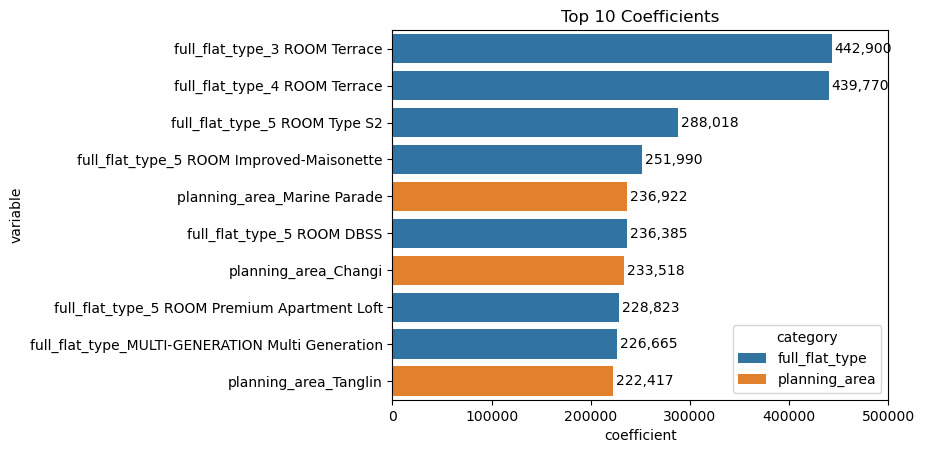

In [15]:
# bar plot of top 10 variables by coefficient and coloured by category 
# (whether absolute value is taken is not important since the smallest negative coefficient is -0.2)
model_coef_top10 = model_coef[:10]

ax = sns.barplot(model_coef_top10, 
            x='coefficient', 
            y='variable',
            hue='category',
            dodge=False
           )

# add data labels
for category in ax.containers:
    ax.bar_label(category, labels=[f'{x:,.0f}' for x in category.datavalues], padding=2);
    
# add title
ax.set_title('Top 10 Coefficients');

# set xlim to avoid clipping the data labels
ax.set_xlim([0,500000]);

Observation:

- 7 out of the top 10 predictor variables are related to the **flat type**, indicating that **flat type** has the largest impact on resale price
- For instance, Terrace HDB has resale prices that is more than \$400k higher than the base flat type of 1 ROOM Improved HDB
- Beyond flat type, **planning area** related variables have large impact on price - Marine Parade/CHangi/Tanglin have resale price is around \$230k compared to Ang Mo Kio (base of comparison)

### Flat type

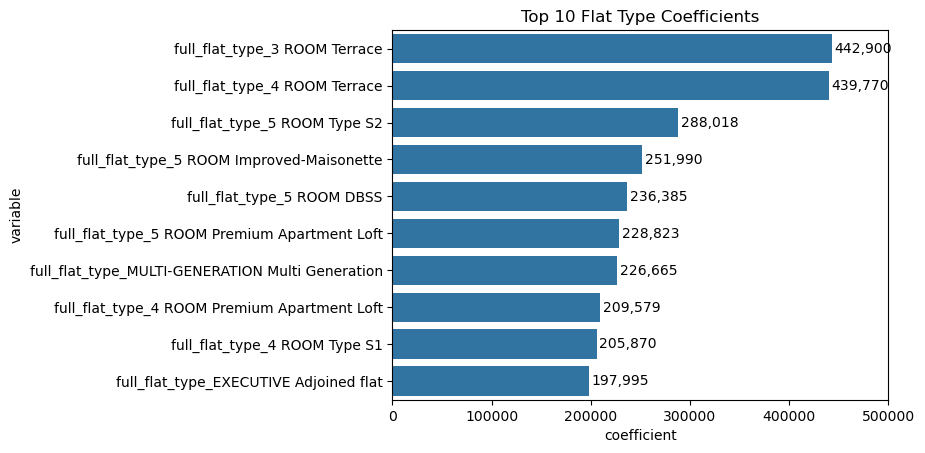

In [16]:
# bar plot of top 10 flat type variables by coefficient and coloured by category 
# (whether absolute value is taken is not important since the smallest negative coefficient is -0.2)
model_coef_top10 = model_coef[model_coef['category'] == 'full_flat_type'][:10]

ax = sns.barplot(model_coef_top10, 
            x='coefficient', 
            y='variable',
            #hue='category',
            color='C0'
           )

# add data labels
for category in ax.containers:
    ax.bar_label(category, labels=[f'{x:,.0f}' for x in category.datavalues], padding=2);
    
# add title
ax.set_title('Top 10 Flat Type Coefficients');

# set xlim to avoid clipping the data labels
ax.set_xlim([0,500000]);

Observation:

- Masionette HDBs have the greatest positive impact on resale price, the number of rooms does not matter as much
- Beyond this flat type, the number of rooms come into play, i.e. the more rooms there are the higher the resale price

### Planning Area

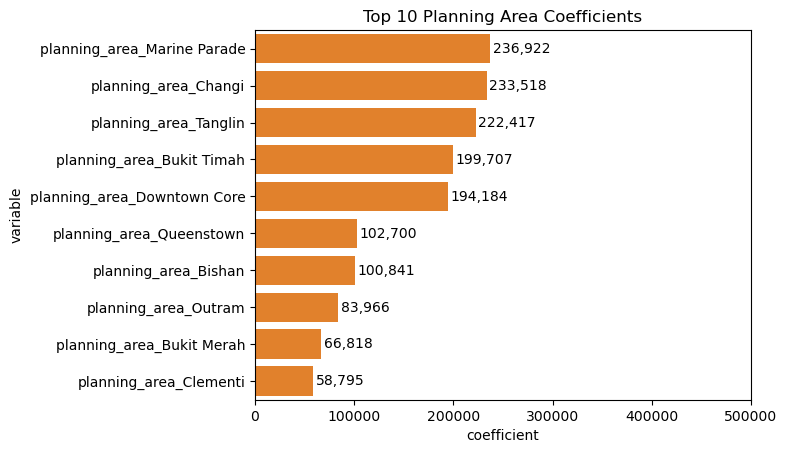

In [17]:
# bar plot of top 10 planning area variables by coefficient and coloured by category 
# (whether absolute value is taken is not important since the smallest negative coefficient is -0.2)
model_coef_top10 = model_coef[model_coef['category'] == 'planning_area'][:10]

ax = sns.barplot(model_coef_top10, 
            x='coefficient', 
            y='variable',
            #hue='category',
            color='C1'     
           )

# add data labels
for category in ax.containers:
    ax.bar_label(category, labels=[f'{x:,.0f}' for x in category.datavalues], padding=2);
    
# add title
ax.set_title('Top 10 Planning Area Coefficients');

# set xlim to avoid clipping the data labels
ax.set_xlim([0,500000]);

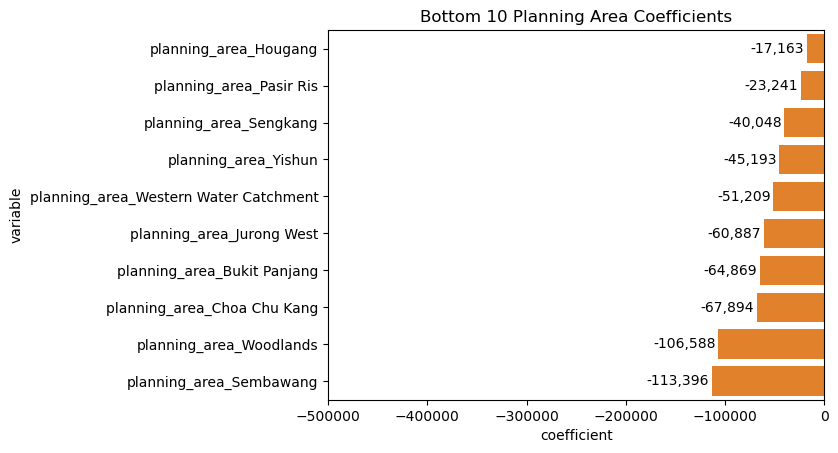

In [18]:
# bar plot of bottom 10 planning area variables by coefficient and coloured by category 
# (whether absolute value is taken is not important since the smallest negative coefficient is -0.2)
model_coef_top10 = model_coef[model_coef['category'] == 'planning_area'][-10:]

ax = sns.barplot(model_coef_top10, 
            x='coefficient', 
            y='variable',
            #hue='category',
            color='C1'     
           )

# add data labels
for category in ax.containers:
    ax.bar_label(category, labels=[f'{x:,.0f}' for x in category.datavalues], padding=2);
    
# add title
ax.set_title('Bottom 10 Planning Area Coefficients');

# set xlim to avoid clipping the data labels
ax.set_xlim([-500000,0]);

Observation:

- HDBs in Marine Parade, Changi and Tanglin have the greatest positive impact on resale price compared to Ang Mo Kio (more than \$200k more)
- The next tier of locations are in Downtown Core and Bukit Timah
- Subsequent locations fetch less than \$100k price difference compared to Ang Mo Kio
- At the other side of the spectrum, Woodlands and Sembawang reduce resale price by more than \$100k

### Amenities

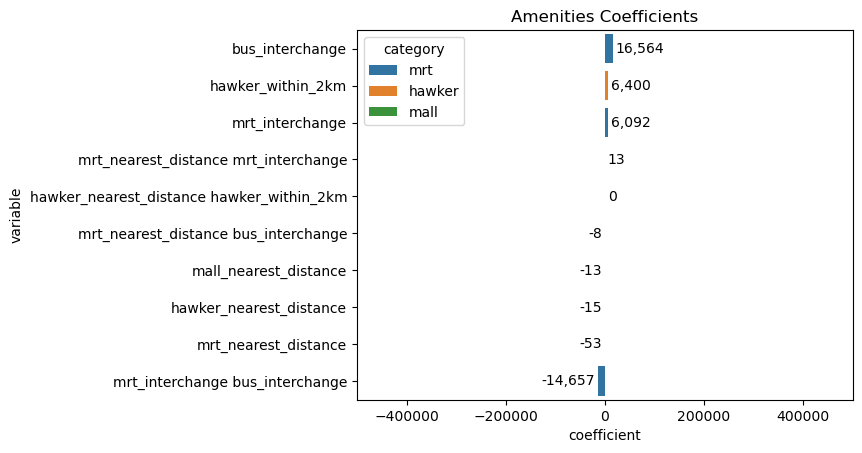

In [19]:
# bar plot of amenities related variables by coefficient and coloured by category 
# (whether absolute value is taken is not important since the smallest negative coefficient is -0.2)
model_coef_amenities = model_coef[(model_coef['category'] == 'mrt') | (model_coef['category'] == 'mall') | (model_coef['category'] == 'hawker')]

ax = sns.barplot(model_coef_amenities, 
            x='coefficient', 
            y='variable',
            hue='category',
            dodge=False
           )

# add data labels
for category in ax.containers:
    ax.bar_label(category, labels=[f'{x:,.0f}' for x in category.datavalues], padding=2);
    
# add title
ax.set_title('Amenities Coefficients');

# set xlim to avoid clipping the data labels
ax.set_xlim([-500000,500000]);

Observation:

- **Effect of amenities on resale price is very small** (less than \$20k)
- Distance to amenities has neligigble effect on resale price, which is surprising
- The presence of a bus interchange at the nearest MRT increases resale price the most by \\$16k, while the MRT being an MRT interchange increase resale pricce by \$6k
- However, the combined effect of a bus and MRT interchange at the nearest MRT has a more muted effect of ard $8k increase in resale price
- the presence of a hawker centre within 2km increases resale price by \$6k


### Other Variables

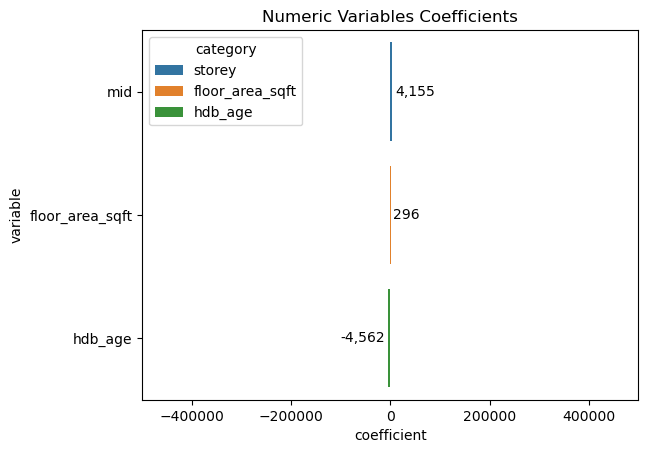

In [20]:
# bar plot of other variables related variables by coefficient and coloured by category 
# (whether absolute value is taken is not important since the smallest negative coefficient is -0.2)
model_coef_others = model_coef[(model_coef['category'] == 'floor_area_sqft') | (model_coef['category'] == 'hdb_age') | (model_coef['category'] == 'storey')]

ax = sns.barplot(model_coef_others, 
            x='coefficient', 
            y='variable',
            hue='category',
            dodge=False
           )

# add data labels
for category in ax.containers:
    ax.bar_label(category, labels=[f'{x:,.0f}' for x in category.datavalues], padding=2);
    
# add title
ax.set_title('Numeric Variables Coefficients');

# set xlim to avoid clipping the data labels
ax.set_xlim([-500000,500000]);

Observation:

- **Every 100sqft increase in the size of the flat, resale price will increase by \\$29.6k**
- **Every 10 floors increase in storey of the flat, resale price will increase by \\$41.6k**
- **Every 10 years older in age of the flat, resale price will decrease by \\$45.6k**

----

## Conclusion and Recommendations

For a potential buyer looking for your HDB, location and flat type are the most influential factors that determine the resale price.

**Location**: A HDB in Marine Parade, Tanglin or Changi can expect to fetch a much higher resale price than other areas (more than \\$200k higher compared to Ang Mo Kio), while those in Woodlands and Sembawang are expected to see the lowest prices (more than \\$100k lower compared to Ang Mo Kio).

**Full Flat Type**: Unless the home owner is selling a Terrace, resale prices will largely follow the number of rooms, e.g., a 5-Room HDB is expected to fetch a higher resale price than a 4-Room HDB regardless of the layout.

**Flat Size**: The resale HDB will be $30k more expensive for every 100 sqft increase in size (i.e. every 100sqft increase in flat size is associated with \\$30k increase in resale price).

**Flat Storey**: A HDB on the 20th floor will be \\$42k more expensive that a similar HDB on the 10th floor (i.e. every 10 floor increase is associated with \\$42k increase in resale price).

**HDB Age**: A decrease in resale price of $46k is associated with every 10 years increase in HDB age.

The presence and distance to amenities such as malls and hawker centres have very little impact to resale prices overall.

### Future Work

This model is very specific to Singapore and may not generalise well to other cities. Nonetheless, to generalise to other cities, we can substitute `planning_area` with some form of measurement of distance to city centre, and simplify `full_flat_type` to just the number of rooms.

In addition, other features currently not in the dataset could be considered to provide a fuller picture of factors that may affect resale price. For instance, the distance to provision shops on top of malls; the distance to coffeeshops on top of hawker centres.